In [1]:
import os
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt


## Downloading UCF50 dataset

In [2]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

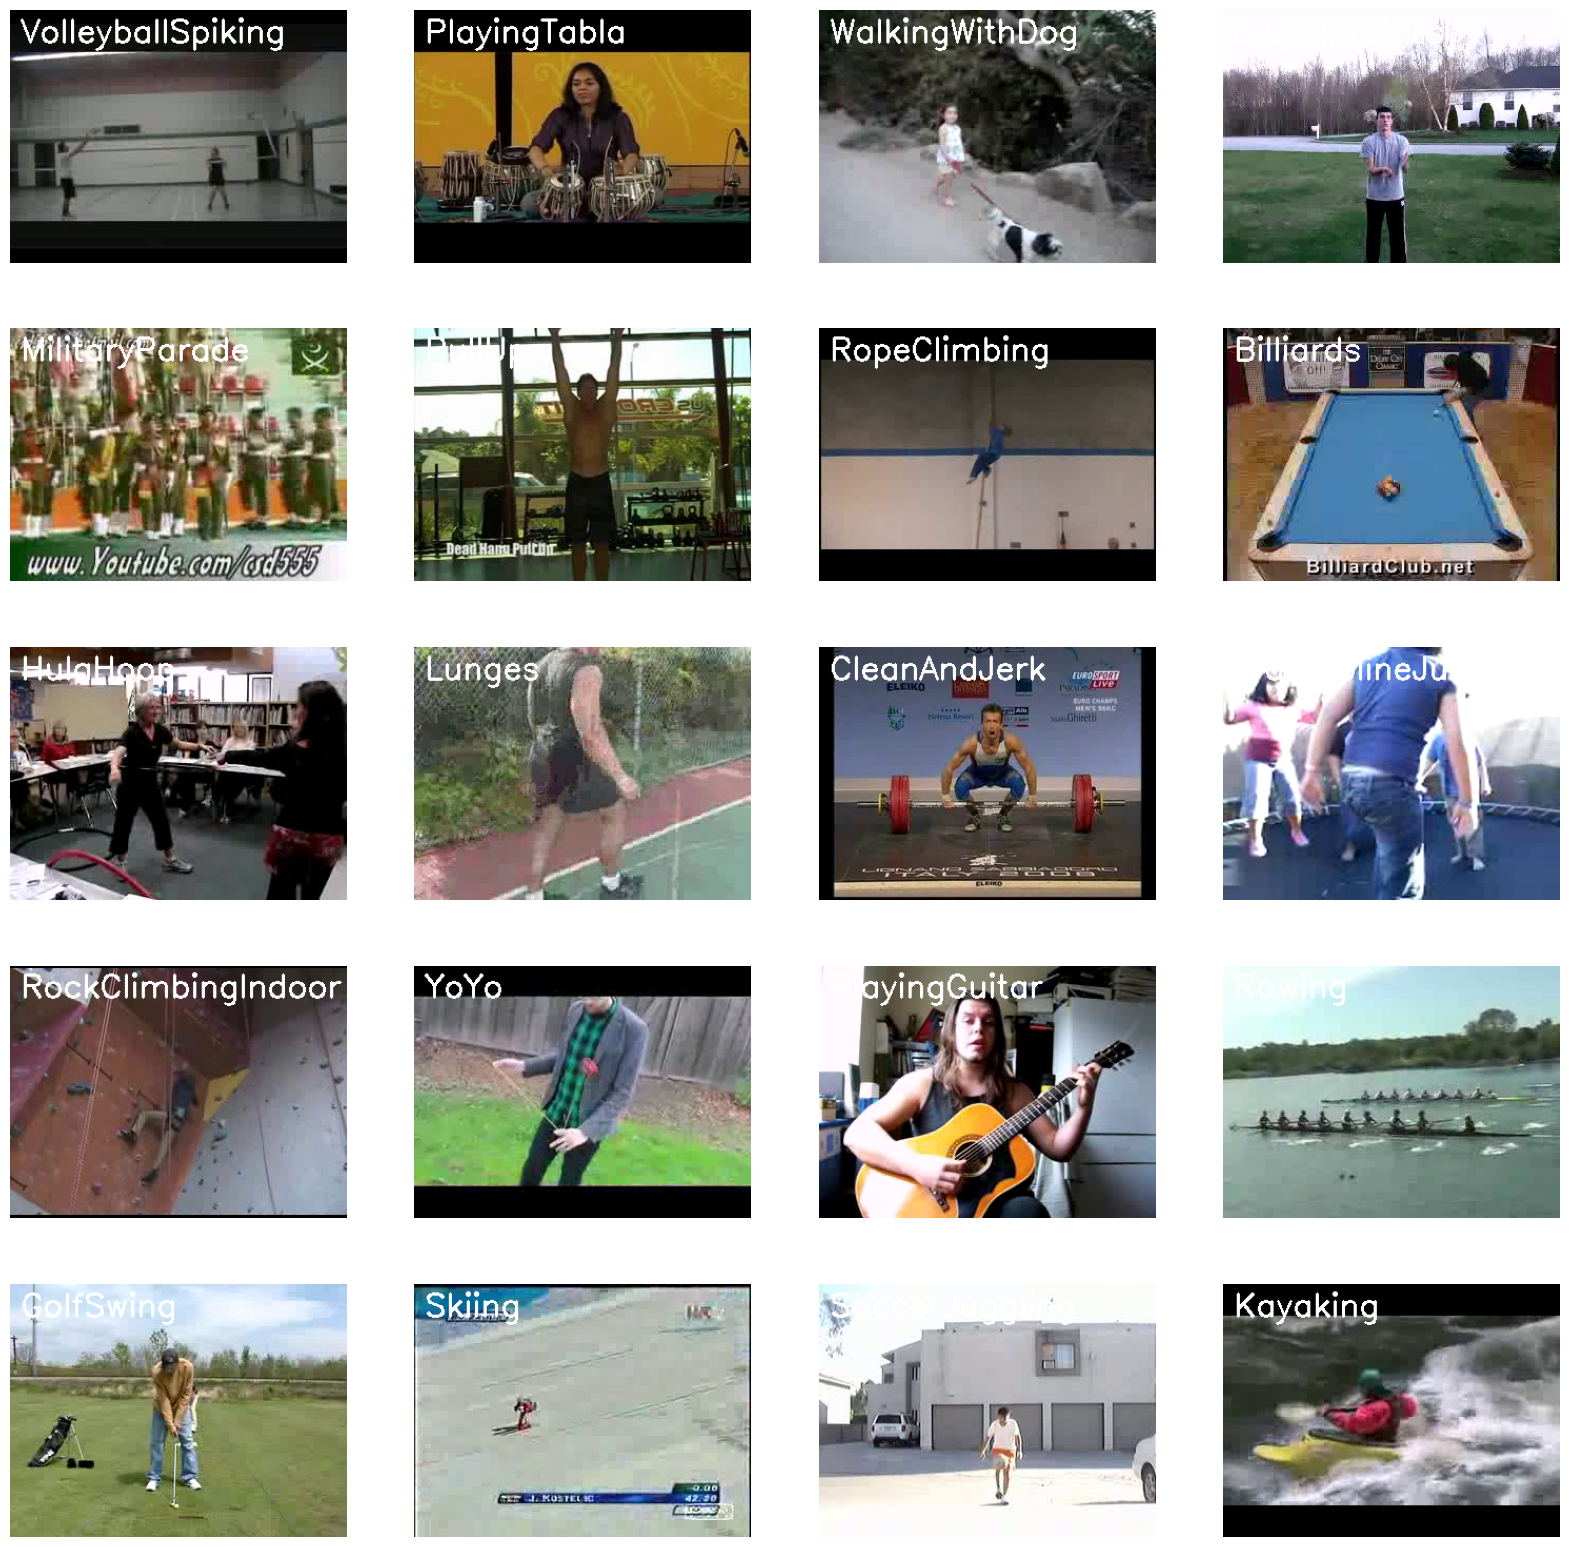

In [3]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('/content/UCF50')

# Extract random classes names from the dataset
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the classses names.
for counter, random_index in enumerate(random_range, 1):

    # select a class name
    selected_class_Name = all_classes_names[random_index]

    # get a list of all the video files that are in the selected Class directory.
    video_files_names_list = os.listdir(f'/content/UCF50/{selected_class_Name}')

    # select a random video file.
    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'/content/UCF50/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    # show the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [4]:

IMAGE_HEIGHT , IMAGE_WIDTH = 96, 96

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

DATASET_DIR = "/content/UCF50"

# Specify some classes from the dataset that the model will train on to recognize these actions.
CLASSES_LIST = ["PlayingGuitar","WalkingWithDog", "HorseRiding", "Basketball"]

In [5]:
def extract_frames(video_path):
    '''
    This function extracts the required frames from a video after resizing and normalizing them.

    '''

    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the number of the intervals that the video will be divivded into
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [6]:
def create_dataset():


    features = [] # frames list
    labels = []   # classes list
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            # Extract the frames of the video file.
            frames = extract_frames(video_file_path)

            # Check if the number of extracted frames equals the sequence length
            # ignoring the vidoes which frames less than the sequence length
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [7]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: PlayingGuitar
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: HorseRiding
Extracting Data of Class: Basketball


In [8]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [9]:
# one hot encoding the labels
one_hot_encoded_labels = to_categorical(labels)

In [10]:
seed_constant = 27
random.seed(seed_constant)


In [11]:
# Split the Data into 75% train set and 25% test set
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## Creating a simple action recognition model

In [12]:
def CNN_LSTM_model():
    '''
    This function constructs the required CNN LSTM model.

    '''

    model = Sequential()

    # Create the sequential model.

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((2, 2))))


    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))


    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))


    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((3, 3))))

    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()


    return model

In [13]:
CNN_LSTM_model = CNN_LSTM_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 96, 96, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 48, 48, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 48, 48, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 24, 24, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 24, 24, 64)    1

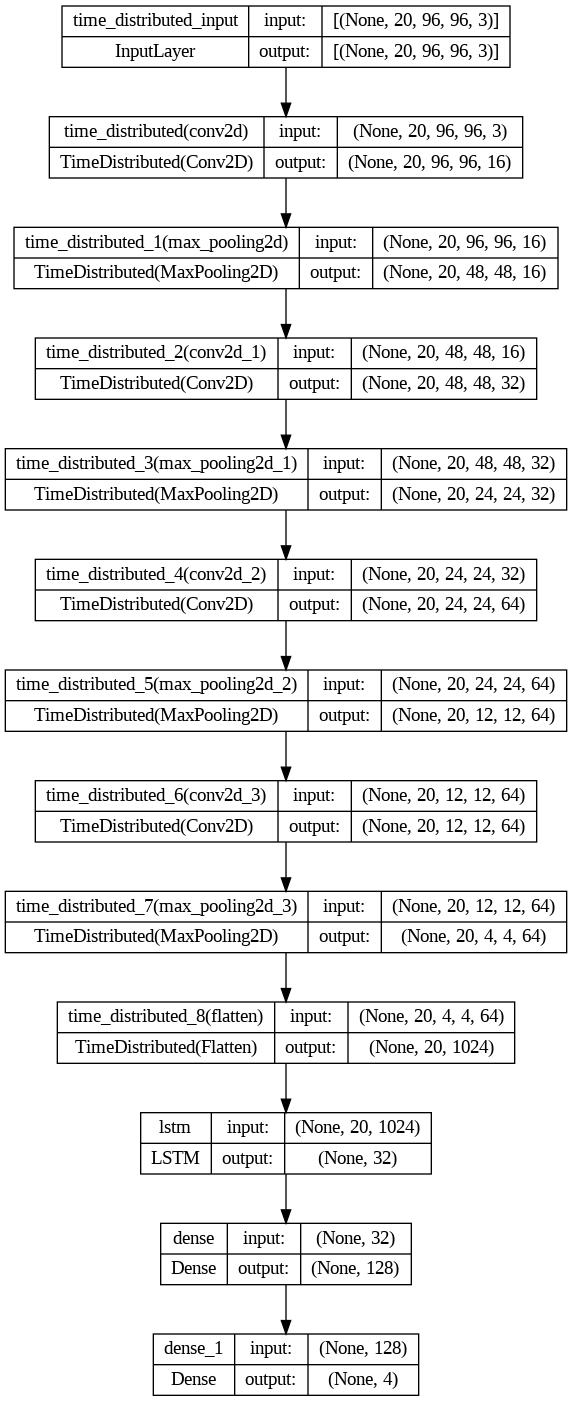

In [ ]:
plot_model(CNN_LSTM_model, to_file = 'CNN_LSTM_Model_Architecture.png', show_shapes = True, show_layer_names = True)


## Training the model for 50 epochs

In [14]:
EarlyStopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

CNN_LSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
# Start training the model
CNN_LSTM_model_training_history = CNN_LSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [EarlyStopping_callback])

Epoch 1/50
93/93 [==============================] - 11s 40ms/step - loss: 1.3522 - accuracy: 0.3577 - val_loss: 1.2337 - val_accuracy: 0.4086
Epoch 2/50
93/93 [==============================] - 2s 22ms/step - loss: 1.0745 - accuracy: 0.5854 - val_loss: 1.0009 - val_accuracy: 0.5914
Epoch 3/50
93/93 [==============================] - 2s 22ms/step - loss: 1.0076 - accuracy: 0.5908 - val_loss: 0.8087 - val_accuracy: 0.6237
Epoch 4/50
93/93 [==============================] - 2s 22ms/step - loss: 0.7229 - accuracy: 0.7073 - val_loss: 0.6274 - val_accuracy: 0.7527
Epoch 5/50
93/93 [==============================] - 2s 23ms/step - loss: 0.6429 - accuracy: 0.7561 - val_loss: 0.9482 - val_accuracy: 0.5914
Epoch 6/50
93/93 [==============================] - 2s 27ms/step - loss: 0.5675 - accuracy: 0.7724 - val_loss: 0.6055 - val_accuracy: 0.6989
Epoch 7/50
93/93 [==============================] - 2s 22ms/step - loss: 0.5050 - accuracy: 0.8049 - val_loss: 0.5936 - val_accuracy: 0.7204
Epoch 8/50
9

In [15]:
model_evaluation_history = CNN_LSTM_model.evaluate(features_test, labels_test)

5/5 [==============================] - 2s 262ms/step - loss: 0.4535 - accuracy: 0.8129


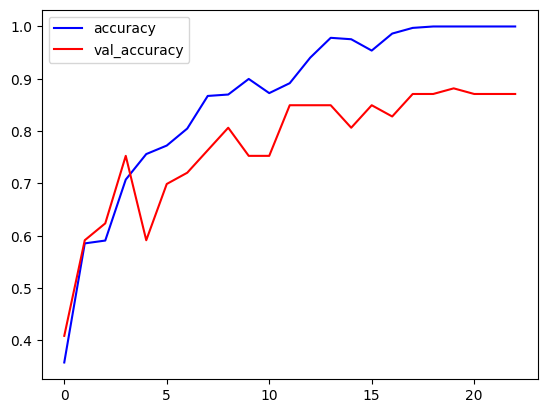

In [16]:
# Get the metrics values
acc = CNN_LSTM_model_training_history.history['accuracy']
val_acc = CNN_LSTM_model_training_history.history['val_accuracy']

epochs = range(len(metric_value_1))

# Plot the Graph.
plt.plot(epochs, acc, 'blue', label = 'accuracy')
plt.plot(epochs, val_acc, 'red', label = 'val_accuracy')

plt.legend()

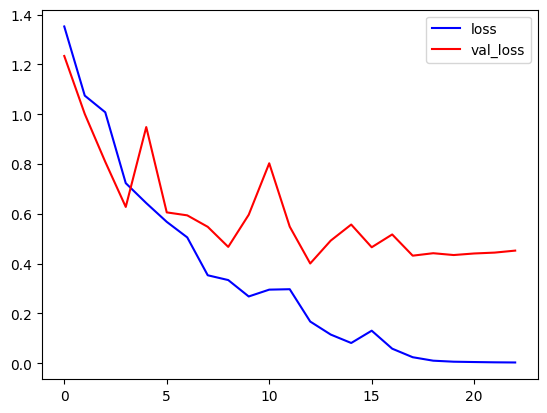

In [17]:

loss = CNN_LSTM_model_training_history.history['loss']
val_loss = CNN_LSTM_model_training_history.history['val_loss']

epochs = range(len(metric_value_1))

# Plot the Graph.
plt.plot(epochs, loss, 'blue', label = 'loss')
plt.plot(epochs, val_loss, 'red', label = 'val_loss')

plt.legend()

In [ ]:
def predict_action(video_path, output_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_path)

    # Get the width and height
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter to save the output video
    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # create queue to store video frames
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize variable to store the predicted action
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the frame dividing it by 255
        normalized_frame = resized_frame / 255

        # Appending the frame into the frames list
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length
        if len(frames_queue) == SEQUENCE_LENGTH:

            # feed the frames into the model to get the predictions
            predicted_labels_probabilities = CNN_LSTM_model_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write the name of the predited class
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
predict_action('/content/video1.mp4', '/content/output3.mp4', 20)

1/1 [==============================] - 0s 21ms/step
